In [1]:
import mne
import os
import numpy as np
from BCOM_processing.SCRIPTS.functions import Preprocessing
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, ICA

In [2]:
#filtering parameters
lowpass=150.#for ERPs and
highpass=0.5#high-pass filtering of MEG is iffy and to be done with caution, better to de-trend epochs. Espaciall bad for MVPA, 0.05 should be safe, remember you might already have high-passed during MF stage. In this case leave 0

ICA_method='fastica' # This is the default method for the package. Although according to the docs, it loooks like picard might be worth trying out (has some better qualities)
# in terms of fastica: data scaled to unit variance + whitened using PCA. Then some first n PCA components are passed to the ICA algo.
# Then, we visualize, repair, and reconstruct the signal with apply mehtod.
# "By default, signal reconstruciton uses all of the ICs, less any ICs listed in ICA.exclude, plus ALL of the PCs that were not inclued in the ICA decomp.
# You can control the exact number with n_pca_components param."

n_components = 25  #of ICA decomposition [which I guess is what is done here]

decim = 3  # we need sufficient statistics, not all time points -> saves time [basically, this will say "select only each 3rd sampling point"]

reject = dict(mag=5e-12)#reject spurious activity, should not be a lot since we MF-ed

bad_loc_chan = 'MEG 173' # bad chan to be removed
# set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this is run
random_state = 23

In [ ]:
f_path = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/c,rfDC'
config_path = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/config'
head_shape_path = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/hs_file'


In [41]:
raw_ica_configs = mne.io.read_raw_bti(pdf_fname=f_path, 
                              config_fname=config_path,
                              head_shape_fname=head_shape_path,
                              rename_channels=True,
                              eog_ch=("EOGv", "EOGh"),
                              ecg_ch="ECG",
                              preload=True,
                              verbose=True,
                              )

Reading 4D PDF file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 1541987  =      0.000 ...   757.916 secs...


In [44]:
raw_ica_configs.info

<Info | 11 non-empty values
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 248 Magnetometers, 2 Stimulus, 23 Reference Magnetometers, 8 misc, 2 EOG, 1 ECG
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: CTF MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 1007 items (3 Cardinal, 1004 Extra)
 highpass: 0.0 Hz
 lowpass: 1017.3 Hz
 meas_date: 2019-04-15 11:13:58 UTC
 nchan: 284
 projs: []
 sfreq: 2034.5 Hz
>

In [42]:
for i, name in enumerate(raw_ica_configs.ch_names):
    if "EOG" in name:
        print(i, name)
for i, name in enumerate(raw_ica_configs.ch_names):
    if "ECG" in name:
        print(i, name)

274 EOG 001
279 EOG 002
275 ECG 001


In [43]:
print(raw_ica_configs.ch_names[274]) #EEG001 - EOGv
print(raw_ica_configs.ch_names[279]) #EEG003 - EOGh
print(raw_ica_configs.ch_names[275]) #EEG002 - ECG

EOG 001
EOG 002
ECG 001


In [17]:
raw_ica_configs.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


2025-04-16 10:30:59.277 python[35039:1152787] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-16 10:30:59.277 python[35039:1152787] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [41]:
raw_ica = mne.io.read_raw_bti(pdf_fname=f_path, 
                            #   config_fname=config_path,
                            #   head_shape_fname=head_shape_path,
                            #   rename_channels=False,
                              preload=True,
                              verbose=True,
                              )

Reading 4D PDF file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_01/MEG/BCOM_01/BCom/04%15%19@03_49/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 1541987  =      0.000 ...   757.916 secs...


In [43]:
for ch1, ch2 in zip(raw_ica.info['chs'], raw_ica_configs.info['chs']):
    pos1 = ch1['loc'][:3]
    pos2 = ch2['loc'][:3]
    if not np.allclose(pos1, pos2, atol=1e-6):
        print(f"Different position for channel {ch1['ch_name']}: {pos1} vs {pos2}")

In [44]:
dig1 = raw_ica.info.get('dig')
dig2 = raw_ica_configs.info.get('dig')

if dig1 and dig2:
    for p1, p2 in zip(dig1, dig2):
        if not np.allclose(p1['r'], p2['r'], atol=1e-6):
            print(f"Dig point mismatch: {p1['r']} vs {p2['r']}")
else:
    print("One or both Raw objects are missing digitization data")

In [45]:
print("Raw 1 dev_head_t:\n", raw_ica.info['dev_head_t'])
print("Raw 2 dev_head_t:\n", raw_ica_configs.info['dev_head_t'])

Raw 1 dev_head_t:
 <Transform | MEG device->head>
[[ 0.99998692  0.00350168  0.00372768  0.00148638]
 [-0.00451716  0.94650698  0.32265173 -0.03080797]
 [-0.00239845 -0.32266434  0.94651042  0.06309179]
 [ 0.          0.          0.          1.        ]]
Raw 2 dev_head_t:
 <Transform | MEG device->head>
[[ 0.99998692  0.00350168  0.00372768  0.00148638]
 [-0.00451716  0.94650698  0.32265173 -0.03080797]
 [-0.00239845 -0.32266434  0.94651042  0.06309179]
 [ 0.          0.          0.          1.        ]]


In [ ]:
np.allclose(raw_ica.get_data(), raw_ica_configs.get_data())

In [ ]:

# in any case, the data is loaded here, and it looks like its bti data type.
# takes in the path to the data, and also preloads. According to the docs,
# this means that the data is 'preloaded' into memory which is apprarently faster, but also requires lots of memory.
# OUT: [Obj]: this returns a Raw object: mne.io.Raw

# raw_ica.resample(300) #NB! this particular version of resample is on the output of the previous line.
# # i.e., it resampels a Raw object. Specifically, it will resample all channels to 300Hz (specified method call)

# raw_ica.filter(highpass, None, n_jobs=1, fir_design='firwin') #applies a filter a 0.5 for the lower pass-band edge. (wait what exactly does this mean?)
# # n_jobs is the number of jobs to run in parallel - I guess since it is set to 1 there is no parallelization
# # fir_design is the design of the FIR filter to use. 'firwin' is the default, and uses the scipy.signal.firwin() method.
# # scipy firwin method computes the coefficients of a finite impulse response filter. The filter will have linear phase;
# # it will be Type I if numtaps is odd and Type II if numtaps is even.
# # Type II filters always have zero response at the Nyquist frequency, so a ValueError exception is raised if firwin is
# # called with numtaps even and having a passband whose right end is at the Nyquist frequency.
# # OUT: [Obj]: this returns a Raw object: mne.io.Raw

# Prep = Preprocessing(raw_ica) #initialize the Preprocessing object with the raw data that we just filtered etc.

# outliers = Prep.get_outliers() #looks for bad channels uisng LocalOutlierFactor() from sklearn.meighbors
# # i.e., it measures the loval deviation of the density of a given sample w/ respect to neighbors.
# # locality is given by k-nearest-neighbors, whose distance is used to estimate the local density.
# # By comparing local density of a sample to the local density of its neighbors, once can id samples that have substantailly
# # lower density than their neighbors - outliers.
# #
# # function first initializes object, then takes the self.Signal part of the Prep object and fits it to the LOF object.
# # it then looks for the outliers in the data, and returns the indices of the outliers.
# # OUT: [List]: the bad channels, which are the outliers.

# flats = Prep.get_flatlines(MaxFlatlineDuration=60, MaxAllowedJitter=1e-5) #is there a bug here? or is 1e-5 interpretted as an int when executed?
# # this step detects flat channels (does this mean that the channels are not recording anything? Or more specifically, that their value is not changing?)
# # takes a number of acceptable seconds of flatlining, as well as a value for the maximum tolerated jitter during the flatlines.
# # First, initialize a np array to store the flat channels.
# # then, loops through the channels in self.Signal, and then for each channel, it checks whether the change in the absolute value of
# # the signal accross time points is less than the MaxAllowedJitter * some computer rep of a floating point number. This is all padded with 'False'.
# # This whole thing is then passed to np.diff which gets the dfference between cons. els. in the padded list. So, the transition from False to True -> 1 which means start of flatline interval
# # and True to False -> -1 which means end of flatline interval. This is then passed to np.where to get the indices of the start and end of the flatline intervals.
# # Finally, we reshape to (2, -1) where each col. representes a start and end index pair. then transposed so each row corresponds to an interval.
# # Then, we check whether any intervals are greater than 0, and if they are, then we look to see if they are longer than the max duration we are ok with.
# # if they are, then we append the channel to the flat channels list.
# # OUT: [List] of flat channels

# bad_chans = [x for x in outliers] #initialize the bad channels list with the outliers

# for flat in flats: #loop through the flat channels
#     if flat not in bad_chans: #if the flat channel is not already in the bad channels list
#         bad_chans.append(flat) #add it to the bad channels list
# if bad_loc_chan in bad_chans: #if the localizer channel is in the bad channels list
#     bad_chans.remove(bad_loc_chan) #remove it from the bad channels list
# bad_chans.sort() #sort the bad channels list

# raw_ica.info['bads'] = bad_chans #set the bad channels in the raw data object to the bad channels list

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.007 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


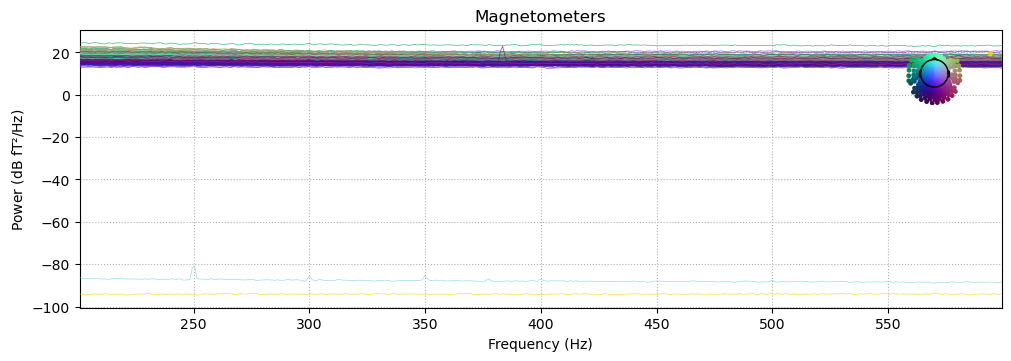

In [25]:
raw_ica.plot_psd(fmin=200, fmax=600, picks='meg')

In [17]:
for ch_name, ch_type in zip(raw_ica.ch_names, raw_ica.get_channel_types()):
    print(f"{ch_name}: {ch_type}")

MEG 001: mag
MEG 002: mag
MEG 003: mag
MEG 004: mag
MEG 005: mag
MEG 006: mag
MEG 007: mag
MEG 008: mag
MEG 009: mag
MEG 010: mag
MEG 011: mag
MEG 012: mag
MEG 013: mag
MEG 014: mag
MEG 015: mag
MEG 016: mag
MEG 017: mag
MEG 018: mag
MEG 019: mag
MEG 020: mag
MEG 021: mag
MEG 022: mag
MEG 023: mag
MEG 024: mag
MEG 025: mag
MEG 026: mag
MEG 027: mag
MEG 028: mag
MEG 029: mag
MEG 030: mag
MEG 031: mag
MEG 032: mag
MEG 033: mag
MEG 034: mag
MEG 035: mag
MEG 036: mag
MEG 037: mag
MEG 038: mag
MEG 039: mag
MEG 040: mag
MEG 041: mag
MEG 042: mag
MEG 043: mag
MEG 044: mag
MEG 045: mag
MEG 046: mag
MEG 047: mag
MEG 048: mag
MEG 049: mag
MEG 050: mag
MEG 051: mag
MEG 052: mag
MEG 053: mag
MEG 054: mag
MEG 055: mag
MEG 056: mag
MEG 057: mag
MEG 058: mag
MEG 059: mag
MEG 060: mag
MEG 061: mag
MEG 062: mag
MEG 063: mag
MEG 064: mag
MEG 065: mag
MEG 066: mag
MEG 067: mag
MEG 068: mag
MEG 069: mag
MEG 070: mag
MEG 071: mag
MEG 072: mag
MEG 073: mag
MEG 074: mag
MEG 075: mag
MEG 076: mag
MEG 077: mag

Fitting ICA to data using 246 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG 227']
Artifact detected in [0, 200]
    Rejecting  epoch based on MAG : ['MEG 177']
Artifact detected in [3600, 3800]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [3800, 4000]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [4000, 4200]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [4200, 4400]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [6800, 7000]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [7600, 7800]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [11800, 12000]
    Rejecting  epoch based on MAG : ['MEG 229']
Artifact detected in [13000, 13200]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [14200, 14400]
    Rejecting  epoch based on MAG : ['MEG 230']
Artifact detected in [18800, 19000]
    Rejectin

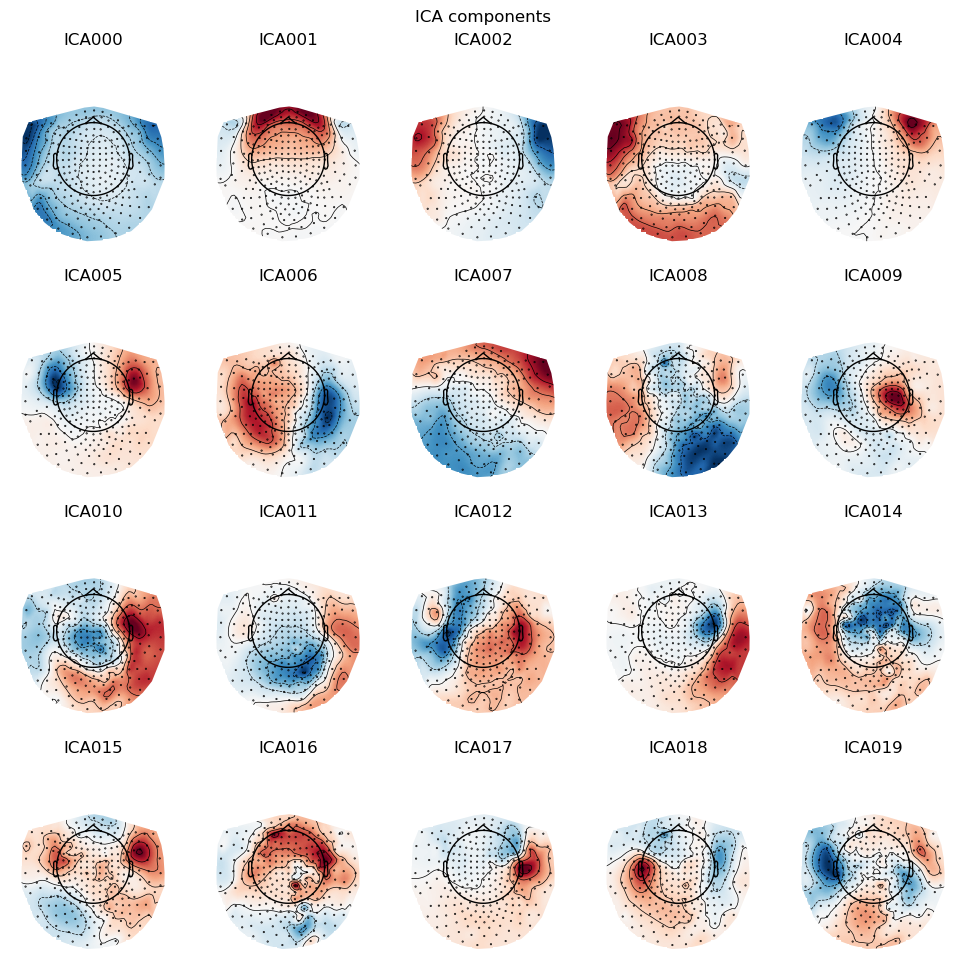

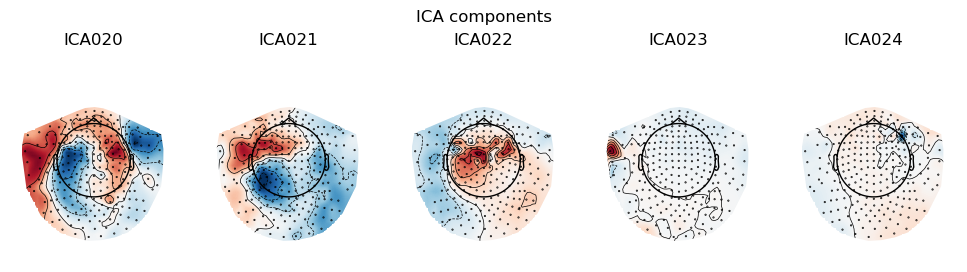

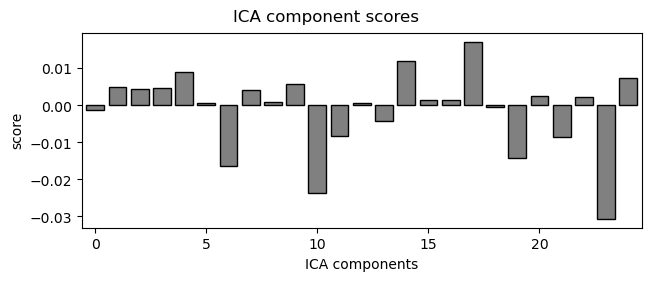

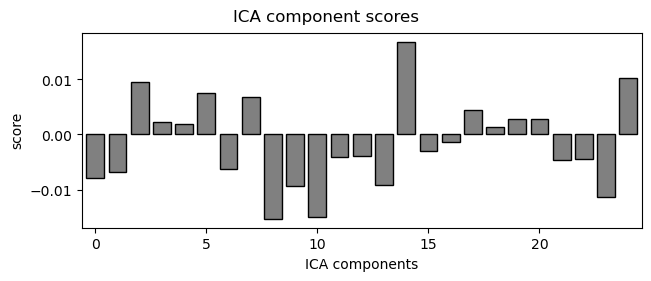

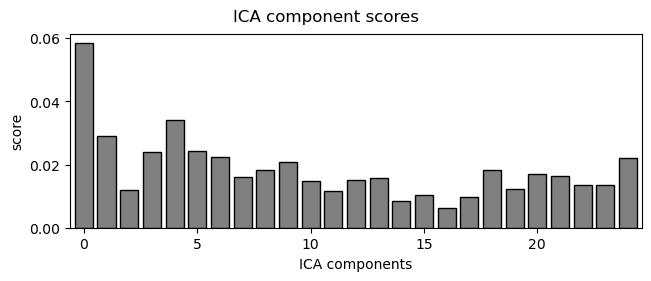

In [9]:
# setup and do ICA
ica = ICA(n_components=n_components, method=ICA_method, #at least in this iteration, uses fast ica
            random_state=random_state)  # define ica object with selected parameters

excluded_chans = [x for x in raw_ica.info['bads']] #initialize the excluded channels list with the bad channels. Don't we already have this
# though in bad_chans? maybe there is more data in raw_ica.info['bads'] than in bad_chans?

excluded_chans.append(bad_loc_chan) #and then we add back the bad_loc_chan? which we removed earlier? Why?

# now we pick the channels that we want to use for ICA
picks = mne.pick_types(raw_ica.info, meg=True, eeg=False, stim=False, eog=False, ecg=False, misc=False, exclude=excluded_chans)
# we only take the MEG channels, and exclude the bad channels (including the localizer channel)

# fit the ICA
ica.fit(raw_ica, picks=picks, decim=decim, reject=reject) #takes the raw data, the picks, the decimation factor, and the type of activity to reject
# and fits the ICA to the data

fig = ica.plot_components(show=False)  # save the component topoplots
for f in fig: #save the stuff
    f.savefig(os.getcwd() + '/' + f.get_children()[1].get_label()[-2:] + '_' + f.get_children()[-2].get_label()[-2:] + '_ICA_comps.png', dpi=300)

# Sort out EOG artifacts
# Now we want to deal with the EOG artifacts by manipulating the EOG channels.
# EOG (Electrooculography) caputres voltage diff. between points around the eyes to detect eye movement or blinking
# MEG is also sensitive to these artifacts, so this channel detects them, and we can remove them afterwards.
EOG_chan = raw_ica.info['ch_names'][-10] # isolate the EOG channel

eog_epochs = create_eog_epochs(raw_ica, ch_name=EOG_chan, reject=reject)  # get single EOG trials eog_epochs = create_eog_epochs(rawica, ch_name=None, reject=reject)# get single EOG trials if No EOG chan
eog_inds, scores = ica.find_bads_eog(eog_epochs,
                                        ch_name=EOG_chan)  # find via pearson correlation; eog_inds, scores = ica.find_bads_eog(eog_epochs,ch_name=None)# if No EOG chan, then manually select the component that looks like blink

#plotting
eogscoresplot = ica.plot_scores(scores, exclude=eog_inds, show=False)
eogscoresplot.savefig(os.getcwd() + '/' + 'eog_r_scores.png', dpi=300)

#this is also a plot, but a plot of the eog properties?
for eog in eog_inds:
    eog_prop = ica.plot_properties(eog_epochs, picks=eog, psd_args={'fmax': 35.}, image_args={'sigma': 1.}, # psd_args refers to the Power Spectral Density plot, setting the max frequency of 35Hz
                                    show=False) # image_args refers to the Gaussian smoothing for the image, being set to 1
    eog_prop[0].savefig(os.getcwd() + '/ICA_' + str(eog) + 'eog_ica_props.png', dpi=300) # save the figure

# remove the top horizontal EOG component - why do we want to do this?
EOG_chan_h = raw_ica.info['ch_names'][-5] #again, isolate channel

eog_epochs_h = create_eog_epochs(raw_ica, ch_name=EOG_chan_h, reject=reject) #same idea, create epochs

eog_h_inds, scores = ica.find_bads_eog(eog_epochs_h, ch_name=EOG_chan_h) #find the bads

eog_hscoresplot = ica.plot_scores(scores, exclude=eog_h_inds, show=False) # why are these h_scores ratehr than r_scores? Is it because they are horizontal?

eog_hscoresplot.savefig(os.getcwd() + '/' + 'eog_h_r_scores.png', dpi=300)

if len(eog_h_inds) >= 1:
    eog_h_inds = [eog_h_inds[0]]  # keep only the first one
    eog_h_prop = ica.plot_properties(eog_epochs_h, picks=eog_h_inds[0], psd_args={'fmax': 35.},
                                        image_args={'sigma': 1.}, show=False)
    eog_h_prop[0].savefig(os.getcwd() + '/ICA_' + str(eog_h_inds[0]) + 'eog_h_ica_props.png', dpi=300)

# sort out ECG artifacts
#
# ECG (electrocardiogram) is a measure of the electrical activity of the heart. This activity can interfere with MEG signals by creating artifacts.
# So, we record it so we can adjust for these artifacts later.
#
ECG_chan = raw_ica.info['ch_names'][-9] #isolate the ECg channel

ecg_epochs = create_ecg_epochs(raw_ica, ch_name=ECG_chan, tmin=-.5, tmax=.5, picks=picks) #so this one is a bit different in that it has different parameters!
# tmin -> the start time before the event; tmax -> the end time after the event; picks -> the channels to include

ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, method='ctps') #NB! uses 'cross trial phase statistics'

# same plotting as before
for ecg in ecg_inds:
    ecg_prop = ica.plot_properties(ecg_epochs, picks=ecg, psd_args={'fmax': 35.}, image_args={'sigma': 1.},
                                    show=False)
    ecg_prop[0].savefig(os.getcwd() + '/ICA_' + str(ecg) + 'ecg_ica_props.png', dpi=300)
ecgscoresplot = ica.plot_scores(scores, exclude=ecg_inds, show=False)
ecgscoresplot.savefig(os.getcwd() + '/' + 'ecg_r_scores.png', dpi=300)

In [10]:
ecg_inds

[]

In [11]:
eog_h_inds

[]

In [12]:
eog_inds

[]